In [1]:
!pip install -q datasets

In [2]:
import numpy as np
import datasets
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from transformers import BertTokenizer,BertModel
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"

In [3]:
dataset = datasets.load_dataset('lex_glue', 'ecthr_a')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1000
    })
})

# Data Understanding

In [4]:
dataset['train']['text'][0]

['11.  At the beginning of the events relevant to the application, K. had a daughter, P., and a son, M., born in 1986 and 1988 respectively. P.’s father is X and M.’s father is V. From March to May 1989 K. was voluntarily hospitalised for about three months, having been diagnosed as suffering from schizophrenia. From August to November 1989 and from December 1989 to March 1990, she was again hospitalised for periods of about three months on account of this illness. In 1991 she was hospitalised for less than a week, diagnosed as suffering from an atypical and undefinable psychosis. It appears that social welfare and health authorities have been in contact with the family since 1989.',
 '12.  The applicants initially cohabited from the summer of 1991 to July 1993. In 1991 both P. and M. were living with them. From 1991 to 1993 K. and X were involved in a custody and access dispute concerning P. In May 1992 a residence order was made transferring custody of P. to X.',
 '13.  K. was again 

In [5]:
# Unique Labels in data
set([j for i in dataset['train']['labels'] for j in i])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [6]:
# Number of Labels per sample Histogram
Counter([len(i) for i in dataset['train']['labels']])

Counter({1: 5924, 0: 914, 2: 1810, 3: 321, 4: 22, 5: 9})

In [7]:
# Number of samples with Missing Labels
sum([1 for i in dataset['train']['labels'] if len(i)==0]),sum([1 for i in dataset['test']['labels'] if len(i)==0]),sum([1 for i in dataset['validation']['labels'] if len(i)==0])

(914, 153, 175)

## Cleaning Missing values

In [8]:
# Missing Labels
def clear_missing_labels(dataset,split):
  missing_label_indexes = [index for index,i in enumerate(dataset[split]['labels']) if len(i)==0]
  dataset[split] = dataset[split].select((i for i in range(len(dataset[split])) if i not in missing_label_indexes))
  return dataset

dataset = clear_missing_labels(dataset,'train')
dataset = clear_missing_labels(dataset,'test')
dataset = clear_missing_labels(dataset,'validation')

dataset

Parameter 'indices'=<generator object clear_missing_labels.<locals>.<genexpr> at 0x7bf8b31c12a0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 8086
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 847
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 825
    })
})

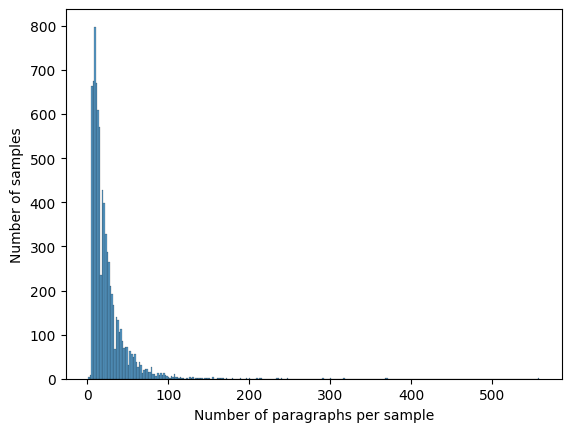

In [9]:
# Number of paragraphs in text
sns.histplot([len(i) for i in dataset['train']['text']])
plt.xlabel('Number of paragraphs per sample')
plt.ylabel('Number of samples')
plt.show()

We may need to truncate the number of pars to 128 for keeping the GPU memory requirements low.

### Cleaning the text

In [10]:
example = '''1.  The case originated in an application (no. 2333/02) against the Republic of Lithuania lodged with the Court under Article 34 of the Convention for the Protection of Human Rights and Fundamental Freedoms (“the Convention”) by a Lithuanian national, Mr Haroldas Trijonis (“the applicant”), on 19 April 2001. 3.  The application was allocated to the Third Section of the Court (Rule 52 § 1 of the Rules of Court). Within that Section, the Chamber that would consider the case (Article 27 § 1 of the Convention) was constituted as provided in Rule 26 § 1. Mr P. Kūris, the judge elected in respect of Lithuania, withdrew from sitting in the case (Rule 28). The Government accordingly appointed Mr J. Hedigan, the judge elected in respect of Ireland, to sit in his place (Article 27 § 2 of the Convention and Rule 29 § 1). 4.  The applicant complained inter alia that criminal proceedings against him had been excessively long contrary to the requirements of Article 6 of the Convention, and that the remand measure of home arrest ordered in the context of those proceedings had breached Article 5 of the Convention. The applicant made his last communication to the Court by an undated letter received on 24 February 2004, stating that he had maintained his complaints under the Convention. 5.  On 1 November 2004 the Court changed the composition of its Sections (Rule 25 § 1). This case was assigned to the newly composed Third Section (Rule 52 § 1). 7.  By a letter of the Registry of 31 March 2005 the applicant was informed about the decision. It was noted in the letter that the applicant had until 23 May 2005 to submit his observations on the merits, his position on the friendly settlement in the case, and his claims for just satisfaction (Rules 59, 60 and 62 of the Rules of Court). The letter was sent to his home address in Klaipeda by ordinary post. 9.  By a letter of the Registry of 21 June 2005, sent to the applicant’s home address by registered post, the applicant was reminded that he had not submitted a reply to the Court’s letter of 31 March 2005. The applicant’s attention was drawn to Article 37 § 1 (a) of the Convention which provided that the Court could strike the case out of its list of cases where the circumstances led to the conclusion that an applicant did not intend to pursue the application. 10.  On 23 September 2005 a further letter of the Registry was sent to the applicant’s home address by registered post, reiterating the contents of the letters of 31 March and 21 June 2005. 11.  Receipt by the applicant of the registered letters of 21 June and 23 September 2005 was confirmed by the post service. However, the applicant has not replied to any of the above-mentioned letters from the Registry of the Court.'''
def split_paras(example):
  '''
  Some times paras are mixed together. We have to seperate them.
  '''
  parts = re.split('(\d+\.  )',example)
  assert len(parts)%2==1
  return [parts[i]+parts[i+1] for i in range(1,len(parts),2)] if len(parts)>1 else parts

def clean_text(example):
  '''
  Text appears mostly clean and does not require any cleaning steps, especially if LLMs are going to be used.
  '''
  s = example.replace('...','').replace('…','').replace('\n',' ')
  s = re.sub('\s+(?:(?<!\d\.)|(?<!\d\d\.)|(?<!\d\d\d\.))',' ',s)
  return s

def preprocess(paras):
  all_paras = []
  for para in paras:
    all_paras.extend(split_paras(para))
  res = []
  for para in all_paras:
    clean_para = clean_text(para)
    if len(clean_para)>=5:
      res.append(clean_para)
  return res

dataset = dataset.map(lambda x:{'text':preprocess(x['text'])})

Map:   0%|          | 0/8086 [00:00<?, ? examples/s]

Map:   0%|          | 0/847 [00:00<?, ? examples/s]

Map:   0%|          | 0/825 [00:00<?, ? examples/s]

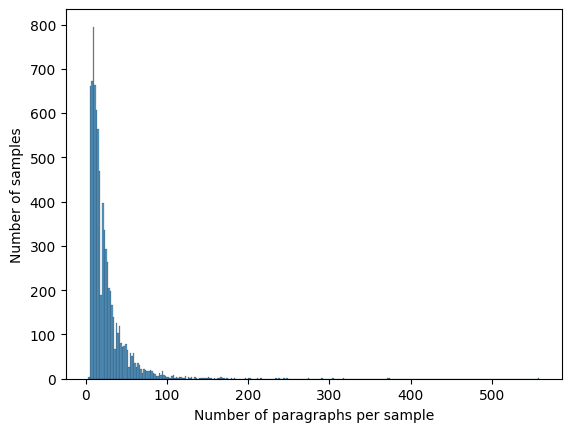

In [11]:

sns.histplot([len(i) for i in dataset['train']['text']])
plt.xlabel('Number of paragraphs per sample')
plt.ylabel('Number of samples')
plt.show()

# Tokenize and truncate

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Only small number of paragraphs are crossing the context length limit, so we can truncate them to 511 tokens. CLS token will be added to all the paragraphs.

In [13]:
model = BertModel.from_pretrained("bert-base-cased")

In [14]:
def data_collator(x):
  # input_ids = [tokenizer(i['text'],padding=True, add_special_tokens=True, truncation=True) for i in x]
  tokens = tokenizer([j for i in x for j in i['text']],add_special_tokens=True, padding=True, truncation=True,return_tensors='pt')
  lens = [len(i['text']) for i in x]

  labels = [[0 for j in range(10)] for i in range(len(x))]
  for index,i in enumerate(x):
    for j in i['labels']:
      labels[index][j]=1
  labels =  torch.Tensor(labels)

  res = []
  count=0
  for i,j in zip(lens,labels):
    res.append({'input_ids':tokens['input_ids'][count:count+i],
                'attention_mask':tokens['attention_mask'][count:count+i],
                'token_type_ids':tokens['token_type_ids'][count:count+i],
                'labels':j})

  return res
  # return {'input_ids':input_ids,'attention_mask':attention_mask,'token_type_ids':token_type_ids,'labels':labels}


train_dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=4,collate_fn = data_collator)
test_dataloader = torch.utils.data.DataLoader(dataset['test'], batch_size=4,collate_fn = data_collator)
validation_dataloader = torch.utils.data.DataLoader(dataset['validation'], batch_size=4,collate_fn = data_collator)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
device = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
class Classifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=768, num_classes=10, num_layers=5, num_heads=8, dropout=0.1):
        super(Classifier, self).__init__()

        self.positional_embedding = nn.Embedding(128, hidden_dim)  # Assuming maximum sequence length of 128
        self.transformer_encoder_layer = TransformerEncoderLayer(hidden_dim, num_heads, hidden_dim, dropout)
        self.transformer_encoder = TransformerEncoder(self.transformer_encoder_layer, num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes,)

    def forward(self, x, attention_mask):
        seq_len = x.shape[1]
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)
        positional_embedded = self.positional_embedding(positions)
        embedded = x + positional_embedded
        embedded = embedded.permute(1, 0, 2)  # (seq_len, batch_size, hidden_dim)
        output = self.transformer_encoder(embedded,src_key_padding_mask = attention_mask)
        output = output.permute(1, 0, 2)  # (batch_size, seq_len, hidden_dim)
        logits = self.fc(output[:, -1, :])  # Take the last hidden state for classification
        # print(logits.shape)
        return logits

clf=Classifier()
clf.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Classifier(
  (positional_embedding): Embedding(128, 768)
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (linear1): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=768, out_features=768, bias=True)
    (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-4): 5 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=768, bias=True)


In [16]:
def batch_texts(tensors):
  max_length = max([tensor.size(0) for tensor in tensors])

  # Pad tensors and create attention mask
  padded_tensors = []
  attention_masks = []
  for tensor in tensors:
      # Pad tensor with zeros
      padded_tensor = torch.zeros(max_length, *tensor.size()[1:])
      padded_tensor[:tensor.size(0)] = tensor
      padded_tensors.append(padded_tensor)

      # Create attention mask
      attention_mask = torch.zeros(max_length)
      attention_mask[:tensor.size(0)] = 1
      attention_masks.append(attention_mask)

  # Convert the list of padded tensors and attention masks to tensors
  padded_tensor = torch.stack(padded_tensors)
  attention_mask = torch.stack(attention_masks)
  return padded_tensor.to(device),attention_mask.to(device)


In [17]:
model.to(device)
import torch.optim as optim

def get_x_and_attention_mask(batch,model):
  X,y  = [],[]
  for microbatch in batch:
    with torch.no_grad():
      B = microbatch['input_ids'].shape[0]
      res = []
      for i in range(1+(B//16)):
        res.append(model(microbatch['input_ids'][i*16:(i+1)*16].to(device), attention_mask = microbatch['input_ids'][i*16:(i+1)*16].to(device)).pooler_output)
      X.append(torch.cat(res))
      y.append(microbatch['labels'])
  y = torch.stack(y).to(device)
  x,attention_mask = batch_texts(X)
  return x,attention_mask,y




In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

def train(model, clf, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch in tqdm(train_dataloader):

            x,attention_mask,labels = get_x_and_attention_mask(batch,model)

            optimizer.zero_grad()

            outputs = clf(x,attention_mask)



            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()



            train_loss += loss.item() * x.size(0)

        train_loss /= train_total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader):
                x,attention_mask,labels = get_x_and_attention_mask(batch,model)

                outputs = clf(x,attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * x.size(0)

        val_loss /= val_total

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f} ")
        print()


In [ ]:
optimizer = optim.Adam(clf.parameters(),lr=0.0001)
criterion = nn.BCEWithLogitsLoss()
train(model,clf,train_dataloader,validation_dataloader,criterion,optimizer,10)

  1%|          | 12/2022 [00:32<1:05:15,  1.95s/it]